# cleaning and feature engineering
1. impute values in Product name column and build new features
2. drop useless columns and rows
2. collapse product identifier, currency to more meaningful and less imbalanced fields
3. new field: client score? (based on how many flagged previous transactions a client has had
4. transform trade amount to log, consider using percentiles.
5. lump together less frequent currencies.
6. one hot encoding.

In [1]:
from src.eda import check_for_nulls

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.graphics.mosaicplot import mosaic
# from tqdm import tqdm_notebook
%matplotlib inline  
plt.rcParams['font.size'] = 16.0
plt.rcParams['figure.figsize'] = (17.0, 6.0)

In [2]:
transactions = pd.read_csv('data/raw/suspicious_transactions_dataset_201812-202001.csv')
display(transactions.head())

,Source System,Leg Type,Trade Date,Product Name,Product Group,Notional Amount Currency,CountryCodeOffice,ML Risk Rating,Client Name,Notional Amount,Gbp Notional Amount,Fx_rate,Flag
0,alpha,CASH,03/12/2018,FX Options,FX DERIV,USD,GB,M,Client_43,202800.0,1.707783e+05,0.842102,0
1,alpha,CASH,03/12/2018,FX Spots,FX TRADES,HKD,GB,L,Client_29,31570000.0,3.128810e+06,0.099107,0
2,alpha,CASH,03/12/2018,FX Forwards,FX TRADES,EUR,GB,M,Client_42,917400.0,8.186487e+05,0.892357,0
3,alpha,CASH,03/12/2018,FX Forwards,FX TRADES,USD,GB,L,Client_51,85800.0,7.225234e+04,0.842102,0
4,alpha,CASH,03/12/2018,FX Forwards,FX TRADES,USD,GB,M,Client_51,110000.0,8.554188e+04,0.777653,0


## 1. impute and augment the data

In [3]:
# impute missing values of product group, given that the product name uniformly maps to product group.
product_name_to_group = {
    'CRS-Vanilla'          : 'CIRS',
    'Deal Related Payment' : 'Miscellaneous Payments',
    'FX Forwards'          : 'FX TRADES',
    'FX NDFs'              : 'FX TRADES',    
    'FX Options'           : 'FX DERIV',
    'FX Spots'             : 'FX TRADES',
    'FX Swaps'             : 'FX TRADES',
    'IRS-ON Index Swap'    : 'IRS',
    'IRS-Vanilla'          : 'IRS',
    'Swaptions'            : 'Swaptions',
}
for key in product_name_to_group:
    transactions.loc[
        (transactions['Product Group'].isna()) 
        & (transactions['Product Name'] == key), 'Product Group'] = product_name_to_group.get(key)

In [4]:
# map from 'Product Name' to new categorization variable: "product_type".
product_name_to_product_type = \
{
    'CRS-Vanilla'          : 'other',
    'Deal Related Payment' : 'other',
    'FX Forwards'          : 'fx_forwards',
    'FX NDFs'              : 'fx_other',    
    'FX Options'           : 'fx_other',
    'FX Spots'             : 'fx_spots',
    'FX Swaps'             : 'fx_swaps',
    'IRS-ON Index Swap'    : 'irs',
    'IRS-Vanilla'          : 'irs',
    'Swaptions'            : 'other',
}
temp_df = pd.DataFrame({'product_name':product_name_to_product_type.keys(), 
                        'product_type': product_name_to_product_type.values()})
transactions = pd.merge(transactions, temp_df, left_on='Product Name', right_on='product_name', how='left')

In [5]:
# augment the date column:
transactions['date'] = pd.to_datetime(transactions['Trade Date'], format='%d/%m/%Y')
print('there are', sum(transactions['date'].isnull()), 'nonsensical date strings')
display(transactions['Trade Date'].describe())
display(transactions['date'].describe(datetime_is_numeric=True))
transactions['month'] = transactions['date'].dt.month
transactions['is_month_start'] = transactions['date'].dt.is_month_start
transactions['is_month_end'] = transactions['date'].dt.is_month_end
transactions['weekday'] = transactions['date'].dt.weekday
transactions['quarter'] = transactions['date'].dt.quarter

there are 0 nonsensical date strings


count          30477
unique           299
top       12/12/2019
freq             260
Name: Trade Date, dtype: object

count                            30477
mean     2019-06-28 02:44:11.363323392
min                2018-12-03 00:00:00
25%                2019-02-26 00:00:00
50%                2019-07-04 00:00:00
75%                2019-10-22 00:00:00
max                2020-01-31 00:00:00
Name: date, dtype: object

## 2. drop useless data
### drop columns that cannot help:
- 'Leg Type': only one value
- 'Notional Amount': not comparable between records due to different currency, and superceded by 'gbp notional amount'
- 'Fx_rate': not relevant to the signal (whether or trade is suspicious)
- 'Procuct Name' and 'Product Group' have been superceded by 'product_type'.
- 'Trade Date' has been superceded by 'date' and more.

In [6]:
transactions.columns

Index(['Source System', 'Leg Type', 'Trade Date', 'Product Name',
       'Product Group', 'Notional Amount Currency', 'CountryCodeOffice',
       'ML Risk Rating', 'Client Name', 'Notional Amount',
       'Gbp Notional Amount', 'Fx_rate', 'Flag', 'product_name',
       'product_type', 'date', 'month', 'is_month_start', 'is_month_end',
       'weekday', 'quarter'],
      dtype='object')

In [7]:
# first, drop useless column. this must be done first because we do not care about missing records in these
useless = ['Leg Type', 'Notional Amount', 'Fx_rate', 'Product Name', 'Product Group', 'Trade Date', 'product_name']
transactions.drop(columns=useless, inplace=True)

### drop incomplete records as they are suspicious:
- flag all records with missing values as 'suspicious' (in the sense "requiring consideration"). 
- it is not unreasonable to expect the information to be present for all transactions. these fields aren't optional. 
- think about why information is missing from a record? is it because it was entered by hand? or joined from a corrupt data source? shouldn't the input be sanitised somewhere upstream?
- whether as an indicator of fraud or failure, records missing values should get flagged for *further consideration*.

In [8]:
# for the rest of the fields, demand that each record is complete. 
# first save incomplete records to file, to report them as requiring further attention
incomplete_records = transactions[transactions.isnull().any(axis=1)]
incomplete_records.to_csv('data/suspicious_records/contain_nulls.csv')
print('wrote', incomplete_records.shape, 'table of incomplete records to file.')
# now drop them
transactions.dropna(axis=0, inplace=True)

wrote (189, 14) table of incomplete records to file.


### drop missing value transactions:
- highly dubious.
- if value of the trade is missing or zero, how can we say that a trade took place? 
- report these records for further consideration as well.
- drop them for purposes of machine learning the pattern of suspicious records.


In [20]:
# next focus on zero value trades. report them, then drop them. 
zero_value_records = transactions[transactions['Gbp Notional Amount'] < 0.01]
zero_value_records.to_csv('data/suspicious_records/zero_amount.csv') 
print('wrote', zero_value_records.shape, 'table of zero amount records to file.')
# now drop them
transactions = transactions[transactions['Gbp Notional Amount'] >= 0.01]

KeyError: 'Gbp Notional Amount'

In [10]:
print('considering only', transactions.shape, 'full records from now on, containing', sum(transactions['Flag']), 'suspicous records')

considering only (30284, 14) full records from now on, containing 169 suspicous records


# featurising 
convert meaningful, complete fields to features for machine learning

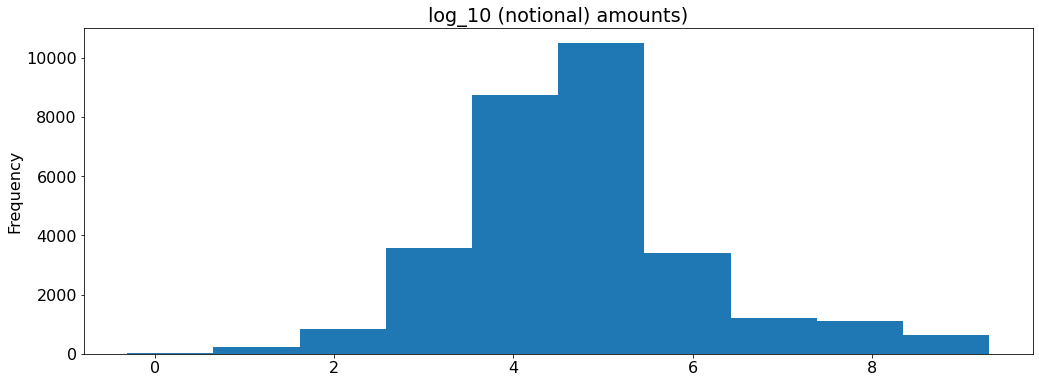

In [11]:
# augment by adding log_amount column
transactions['gbp_log_amount'] = np.log10(transactions['Gbp Notional Amount'])
transactions['gbp_log_amount'].describe()
transactions['gbp_log_amount'].plot.hist(title='log_10 (notional) amounts)')
plt.show()

In [12]:
transactions.drop(columns='Gbp Notional Amount', inplace=True)  # superceded by log of gbp.

In [13]:
# convert from notional amount currency to a simplified currency_feature.
transactions['Notional Amount Currency'].sort_values().unique()
currency_to_currency_simplified = {
    'AED': 'AED',
    'AUD': 'AUD',
    'BRL': 'other',
    'CAD': 'CAD',
    'CHF': 'other',
    'CNH': 'other',
    'CZK': 'other',
    'DKK': 'DKK',
    'EUR': 'EUR',
    'HKD': 'other',
    'HUF': 'other',
    'ILS': 'other',
    'INR': 'other',
    'JPY': 'JPY',
    'MAD': 'other',
    'MXN': 'MXN',
    'NOK': 'other',
    'NZD': 'NZD',
    'PLN': 'PLN',
    'RUB': 'other',
    'SEK': 'SEK',
    'SGD': 'other',
    'THB': 'other',
    'TRY': 'other',
    'USD': 'USD',
    'ZAR': 'ZAR',
}
temp_df = pd.DataFrame({'currency_all':currency_to_currency_simplified.keys(), 
                        'currency_reduced': currency_to_currency_simplified.values()})
transactions = pd.merge(transactions, temp_df, left_on='Notional Amount Currency', right_on='currency_all', how='left')\
    .drop(columns=['Notional Amount Currency', 'currency_all', ])


# 2.0 client score
- feature idea: consider each client's number of previous suspicious transactions.
- must make sure to only determine a client's propensity for being flagged from training and validation data, and not from validation (holdout) data. 
- skipped for the sake of time



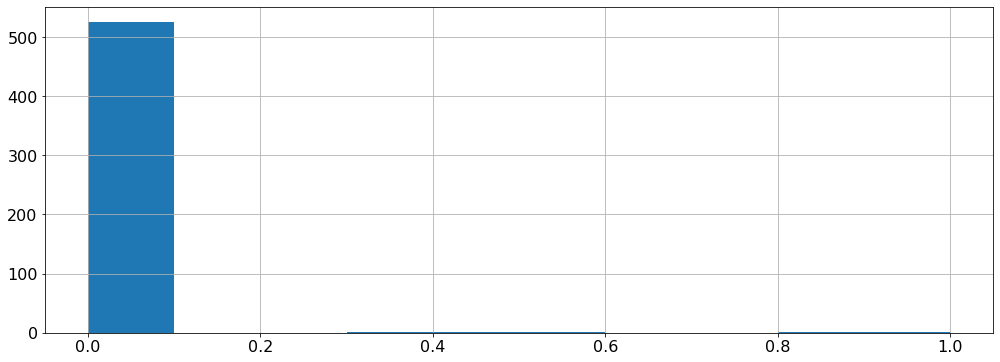

In [14]:
clients = pd.Series(transactions['Client Name'].unique()).sort_values()
num_trans_client = transactions['Client Name'].value_counts().sort_index()
num_flags_client = transactions[transactions['Flag']==1]['Client Name'].value_counts().sort_index()

client_summary = pd.DataFrame({'num_flags': num_flags_client, 'num_transactions': num_trans_client}, index=clients)
client_summary.fillna(value=0, inplace=True)
client_summary['ratio'] = client_summary['num_flags']/client_summary['num_transactions']
client_summary['ratio'].hist(title='ratio of flagged transactions')
client_summary['client_name'] = client_summary.index
plt.show()

In [15]:
client_summary

,num_flags,num_transactions,ratio,client_name
Client_0,4.0,5,0.800000,Client_0
Client_1,1.0,47,0.021277,Client_1
Client_10,0.0,18,0.000000,Client_10
Client_100,0.0,89,0.000000,Client_100
Client_101,5.0,122,0.040984,Client_101
...,...,...,...,...
Client_95,0.0,20,0.000000,Client_95
Client_96,0.0,257,0.000000,Client_96
Client_97,0.0,13,0.000000,Client_97
Client_98,0.0,23,0.000000,Client_98


<AxesSubplot:title={'center':'number of transactions per client distribution'}, ylabel='Frequency'>

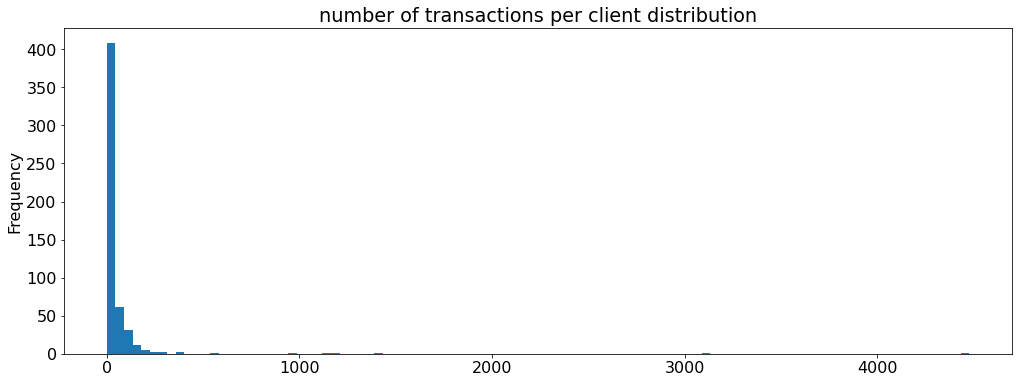

In [16]:
client_summary['num_transactions'].plot.hist(bins=100, title="number of transactions per client distribution")

In [17]:
# mark whether client has made many trades before or not
client_summary['new_client'] = client_summary['num_transactions'] < 20
client_summary['frequent_client'] = client_summary['num_transactions'] >100


# plot of ratio shows majority of clients have not been tagged as suspicious (ratio=0)
client_summary['suspicious_client'] =\
    ((client_summary['ratio']>0.6) & (client_summary['num_transactions']>5)) 
client_summary['trusted_client'] = (client_summary['ratio']<0.01) & (client_summary['num_transactions']>99)
client_summary['client_name'] = client_summary.index


transactions = pd.merge(transactions, 
                        client_summary[['suspicious_client', 'trusted_client', 'client_name', 'new_client', 'frequent_client' ]], 
                        left_on='Client Name', right_on='client_name', how='left')\
    .drop(columns=['Client Name'])
transactions.head()

,Source System,CountryCodeOffice,ML Risk Rating,Flag,product_type,date,month,is_month_start,is_month_end,weekday,quarter,gbp_log_amount,currency_reduced,suspicious_client,trusted_client,client_name,new_client,frequent_client
0,alpha,GB,M,0,fx_other,2018-12-03,12,False,False,0,4,5.232433,USD,False,False,Client_43,False,False
1,alpha,GB,L,0,fx_spots,2018-12-03,12,False,False,0,4,6.495379,other,False,False,Client_29,True,False
2,alpha,GB,M,0,fx_forwards,2018-12-03,12,False,False,0,4,5.913098,EUR,False,False,Client_42,True,False
3,alpha,GB,L,0,fx_forwards,2018-12-03,12,False,False,0,4,4.858852,USD,False,False,Client_51,True,False
4,alpha,GB,M,0,fx_forwards,2018-12-03,12,False,False,0,4,4.932179,USD,False,False,Client_51,True,False


In [18]:
transactions.dtypes

Source System                object
CountryCodeOffice            object
ML Risk Rating               object
Flag                          int64
product_type                 object
date                 datetime64[ns]
month                         int64
is_month_start                 bool
is_month_end                   bool
weekday                       int64
quarter                       int64
gbp_log_amount              float64
currency_reduced             object
suspicious_client              bool
trusted_client                 bool
client_name                  object
new_client                     bool
frequent_client                bool
dtype: object

In [19]:
transactions.to_parquet('data/data_products/suspicious_transactions_dataset_201812-202001_cleaned.parquet')

# next step:
see notebook `case_study_modelling.ipynb`